# Building a neural network with different activation functions

We've discussed in class that one of the advantages of neural networks lies in their ability to capture nonlinearity. We'll see that in action now as we try to classify a circular dataset.

For that we will use kernels to capture nonlinearity. You've seen this work before in Support Vector Machines. I like to imagine kernels as a way to "push" data into other feature spaces to allow us to separate it. The Wikipedia article on kernel machines (https://en.wikipedia.org/wiki/Kernel_method) has a very intuitive picture for that process: if we have a scatterplot in two dimensions, we can "push" a kernel through that cloud of dots in order to separate them. Points of one class are suddenly pushed upwards into the new dimension as they are "on top" of the kernel shape. We are expanding the dimensions by one using the kernel and can now find a linear classifier that cuts through the kernel, separating the points "on top" from those "on the bottom". Different kernel shapes exist for different scenarios.

## Dataset - circles

Let's generate some data ourselves for this example.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles, make_checkerboard
import matplotlib.pyplot as plt

# scikit-learn offers a method to create a similar dataset
X, y = make_circles(n_samples=1000, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

print(df.head())

          x         y  label
0 -0.736801  0.453909      1
1  0.677176  0.475985      1
2 -0.058268  0.890845      1
3 -0.393941 -0.594823      1
4  0.907067  0.500252      0


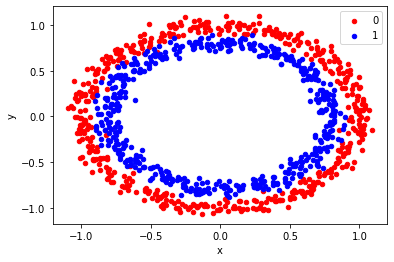

In [2]:
# Plotting the dataset
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

You can see that this will be a tricky example for any linear classifier. There's no way of drawing a line through this space to separate the two classes. A SVM might work well and, as we will see in this example, a neural network handles it well too.

We first create a training and test set:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Linear kernel

Now, we create a neural network with two hidden layers, and a linear kernel. Notice that we also run the algorithm 10 times/epochs.

One epoch refers to one complete run of the whole training dataset through the network. You'll remember that we're running through forward once and then backward once to update our weights and biases (backpropagation). When we've completed that cycle, we've run one epoch. Running multiple epochs (by then pushing the same data through again) can improve the performance of your network, so it's common to run at least a few.

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam

# As before, specify the size of our input and output.
input_dim = X_train.shape[1]
output_dim = 1

# We're building a sequential model again.
model = Sequential()

# Add the input layer and connect to 50 hidden neurons
model.add(Dense(50,input_dim=input_dim))

# See the activation type of the layer. Before, we only added this layer as a very last layer to change
# our output, but here we can transform the data while feeding it through the layers.
model.add(Activation('linear'))

# Extra hidden layer can be added like this
model.add(Dense(50))
model.add(Activation('linear'))

# Connect the previous layer to the output layer
model.add(Dense(output_dim))

# Add a final layer for classification based on the sigmoid function. This will allows us the binary
# classification into 1/0 that we're looking for.
model.add(Activation('sigmoid'))

# We use a different optimiser here instead of stochastic gradient descent
# This is not important now, but it shows you that options exist for different scenarios.
model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])

# Fit to training data, test on test data and print a summary output.
model.summary()
model.fit(X_train,y_train,epochs=10)
prediction_prob = model.predict(X_test)
prediction_class = (prediction_prob > 0.5).astype("int32")

print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                150       
                                                                 
 activation_6 (Activation)   (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 activation_7 (Activation)   (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
 activation_8 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-traina

Notice the last two lines of your output: our accuracy and AUC are very low around 0.48, so clearly a linear approach to this problem doesn't work. We're basically classifying at random at the moment. Clearly, the network is having a hard time coming up with good results. The linear kernel will just not be able to capture the shapes in the data adequately. Let's try a different kernel.

## ReLU kernel

We can easily change the code above to use a different kernel, e.g., the rectified linear unit. 

There's a lot of different shapes you could choose here - the Keras documentation covers them.
https://keras.io/api/layers/activations/
You'll recognise for example 'sigmoid' and 'softmax' from that list.

In [5]:
input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50,input_dim=input_dim))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(output_dim))

model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
model.fit(X_train,y_train,epochs=10)
prediction_prob = model.predict(X_test)
prediction_class = (prediction_prob > 0.5).astype("int32")

print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                150       
                                                                 
 activation_3 (Activation)   (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 activation_4 (Activation)   (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
 activation_5 (Activation)   (None, 1)                 0         
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-traina

That's not a bad result. You will notice that, when running the model multiple times, the result is not very stable. Nevertheless, the ReLU kernel will at least be able to break that 50% accuracy barrier that the linear kernel had because it can't predict the outcome and ends up in random guessing (or just drawing a straight line through the middle - which is the same in the case of the circles).

You could experiment with other kernel shapes here if you so wish.